# <b> <center> <font color="#0E6655"> CARS - HIERARCHICAL CLUSTERING </font> </center> </b>

## <font color='blue'> <b> Table of Contents </b> </font>

1. [Introduction](#1)
2. [Modules](#2)
3. [Loading, exploring and pre-processing data](#3)
4. [Hierarchical Clustering with Scipy](#4)
5. [Hierarchical Clustering with ScikitLearn](#5)
6. [ANNEX](#annex)
7. [References](#references)


<a name="1"></a>
## <b> <font color='green'> 1. Introduccion </a>


Imagine that a car manufacturer has developed prototypes for a new vehicle. Before introducing the new model, the manufacturer wants to determine which existing vehicles in the market are most similar to the prototype; that is, how vehicles can be grouped, which group is most similar to this model, and therefore against which models it will compete.

Our goal is to use clustering methods to find the most distinctive clusters of vehicles. It will summarize existing vehicles and help manufacturers make a decision about supplying new models.

<a name="2"></a>
## <b> <font color='green'> 2. Modules </a>

In [57]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold, datasets

from scipy import ndimage
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import distance_matrix

from warnings import simplefilter
from scipy.cluster.hierarchy import ClusterWarning
simplefilter("ignore", ClusterWarning)


<a name="3"></a>
## <b> <font color='green'> Loading, exploring and pre-processing data </a>

In [9]:
!cd data && ls

cars.csv


In [10]:
df = pd.read_csv('data/cars.csv')
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


In [11]:
df.shape

(159, 16)

In [12]:
df.dtypes

manufact      object
model         object
sales         object
resale        object
type          object
price         object
engine_s      object
horsepow      object
wheelbas      object
width         object
length        object
curb_wgt      object
fuel_cap      object
mpg           object
lnsales       object
partition    float64
dtype: object

### Pre-processing

We're going to:

- Convert features to numerical
- Drop rows with NaN values
- Select a few features
- Normalize numerical features


In [14]:
print ("Shape of dataset before cleaning: ", df.size)

# convert features to numerical (those who should be numerical)
df[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = df[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')


# drop rows with nan values
df = df.dropna()
df = df.reset_index(drop=True)

print ("Shape of dataset after cleaning: ", df.size)
df.head(5)

Shape of dataset before cleaning:  1872
Shape of dataset after cleaning:  1872


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


In [16]:
# select just a few features
featureset = df[['engine_s',  'horsepow', 'width', 'length', 'fuel_cap', 'mpg']]

In [18]:
# normalization

x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:2]

array([[0.11428571, 0.21518987, 0.28143713, 0.30625832, 0.13364055,
        0.43333333],
       [0.31428571, 0.43037975, 0.46107784, 0.5792277 , 0.31797235,
        0.33333333]])

All values are now between 0 and 1.

<a name="4"></a>
## <b> <font color='green'> 4. Hierarchical clustering with SciPy </a>
    
We are going to implement hierarchical clustering with SciPy.

In [22]:
# distance matrix
leng = feature_mtx.shape[0]
D = np.zeros((leng, leng))

for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])

In [23]:
D

array([[0.        , 0.48689625, 0.58602457, ..., 0.23007097, 0.19136392,
        0.17803683],
       [0.48689625, 0.        , 0.14630061, ..., 0.32741937, 0.60647595,
        0.5404592 ],
       [0.58602457, 0.14630061, 0.        , ..., 0.41608439, 0.68728413,
        0.61413197],
       ...,
       [0.23007097, 0.32741937, 0.41608439, ..., 0.        , 0.36941548,
        0.30579706],
       [0.19136392, 0.60647595, 0.68728413, ..., 0.36941548, 0.        ,
        0.11131274],
       [0.17803683, 0.5404592 , 0.61413197, ..., 0.30579706, 0.11131274,
        0.        ]])

In agglomerative clustering, at each iteration, the algorithm must update the distance matrix to reflect the distance of the newly formed clusters with the remaining ones.
The following methods are supported in Scipy for calculating distances between clusters:


```
- single
- complete
- average
- weighted
- centroid
```

We are going to use **complete**

In [29]:
#import scipy.cluster.hierarchy
Z = hierarchy.linkage(D, 'complete')

Essentially, hierarchical clustering does NOT require a pre-established number of clusters. However, in some applications, we want a partition of disjoint clusters as in "flat clustering." Then, you can use a cut-off line.

In [32]:
max_d = 3
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 4, 4, 5, 3, 3, 5, 4, 4, 4, 3, 4, 3, 3, 4, 5, 5, 4, 4, 4, 2, 1,
       9, 5, 5, 3, 5, 3, 5, 5, 5, 8, 6, 6, 6, 3, 3, 1, 4, 5, 4, 7, 4, 3,
       7, 4, 6, 1, 5, 5, 4, 3, 1, 5, 5, 4, 1, 4, 4, 4, 4, 3, 3, 7, 1, 5,
       5, 4, 4, 4, 5, 5, 5, 4, 7, 4, 3, 5, 4, 3, 2, 1, 5, 4, 3, 4, 5, 3,
       4, 3, 5, 5, 3, 5, 5, 4, 4, 4, 5, 4, 4, 1, 1, 1, 1, 5, 4, 1, 5, 1,
       5, 7, 1, 5, 5, 1, 1], dtype=int32)

In [33]:
# distinct clusters
set(clusters)

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [34]:
# we can also preset the number of clusters 
k = 5
clusters = fcluster(Z, k, criterion='maxclust')
clusters


array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       5, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3, 2, 2, 1, 2, 2, 2, 3, 2, 2,
       3, 2, 3, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1,
       2, 3, 1, 2, 2, 1, 1], dtype=int32)

In [35]:
set(clusters)

{1, 2, 3, 4, 5}

### Dendogram

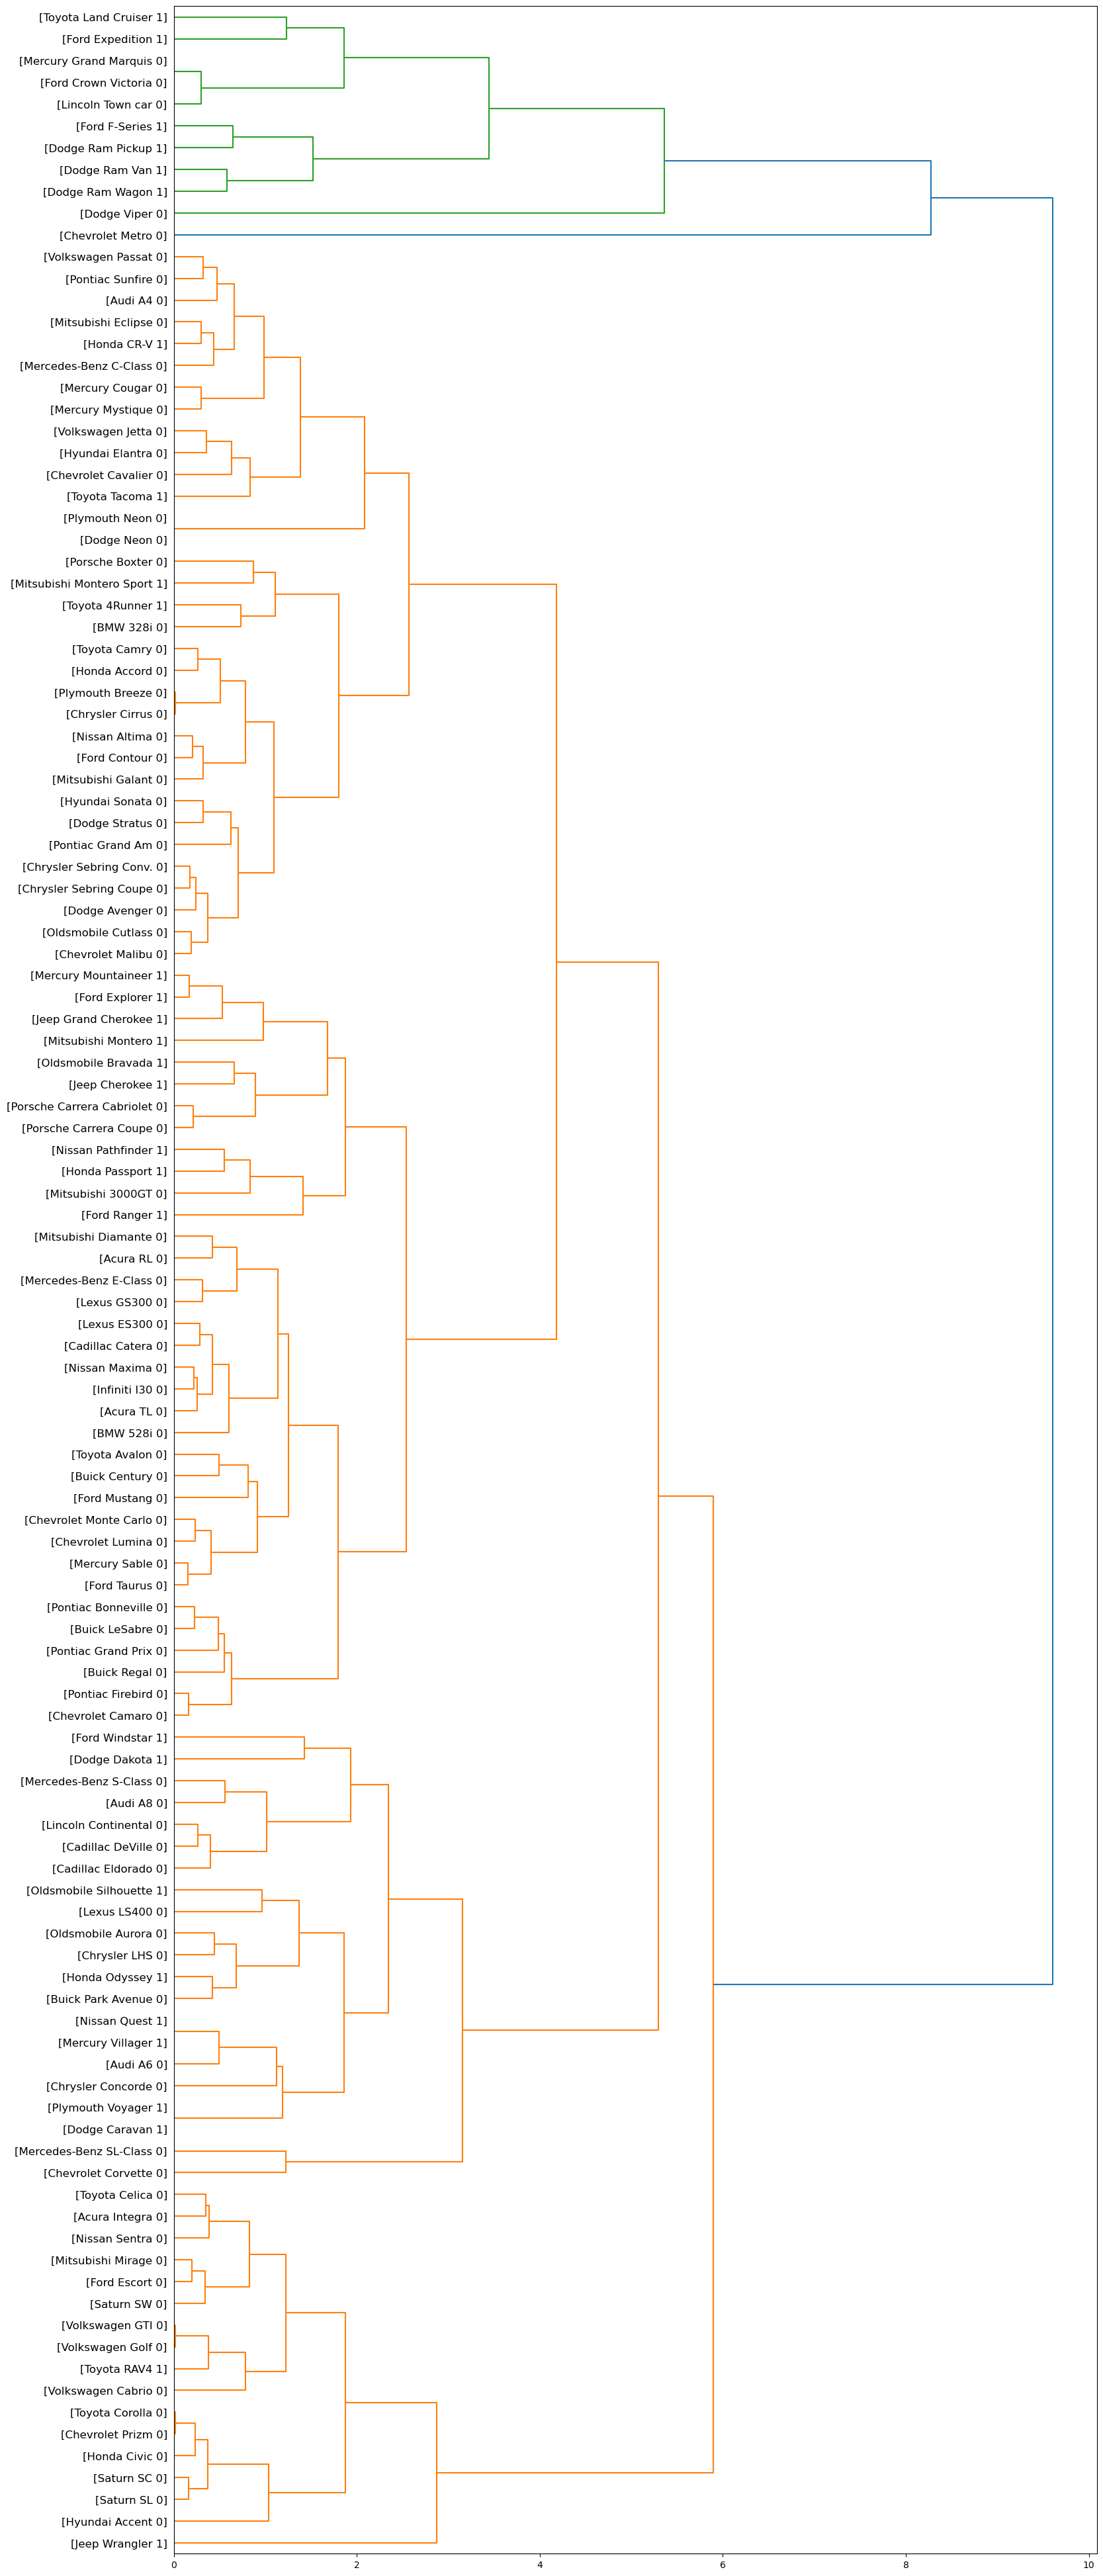

In [38]:
fig = pylab.figure(figsize=(18,50))

def llf(id):
    return '[%s %s %s]' % (df['manufact'][id], df['model'][id], int(float(df['type'][id])) )
    
dendro = hierarchy.dendrogram(Z,  
                              leaf_label_func=llf, 
                              leaf_rotation=0, 
                              leaf_font_size =12, 
                              orientation = 'right')

<a name="5"></a>
## <b> <font color='green'> 5. Hierarchical clustering with ScikitLearn </a>
    
Now, we're gonna use SickitLearn.

In [40]:
dist_matrix = distance_matrix(feature_mtx,feature_mtx) 
dist_matrix

array([[0.        , 0.48689625, 0.58602457, ..., 0.23007097, 0.19136392,
        0.17803683],
       [0.48689625, 0.        , 0.14630061, ..., 0.32741937, 0.60647595,
        0.5404592 ],
       [0.58602457, 0.14630061, 0.        , ..., 0.41608439, 0.68728413,
        0.61413197],
       ...,
       [0.23007097, 0.32741937, 0.41608439, ..., 0.        , 0.36941548,
        0.30579706],
       [0.19136392, 0.60647595, 0.68728413, ..., 0.36941548, 0.        ,
        0.11131274],
       [0.17803683, 0.5404592 , 0.61413197, ..., 0.30579706, 0.11131274,
        0.        ]])

Now we can use the "AgglomerativeClustering" function from scikit-learn, which performs hierarchical clustering using a bottom-up approach. The linkage criterion determines the metric used for the merging strategy:

- **Ward** minimizes the sum of squared differences within all clusters. It's a minimum variance approach and in this sense, it's similar to the objective function of k-means but tackled with an agglomerative clustering approach.
- **Maximum** or **complete** linkage minimizes the maximum distance between observations of pairs of clusters.
- **Average** minimizes the average distance between observations of pairs of clusters.


In [41]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(feature_mtx)
agglom.labels_

array([2, 4, 4, 2, 4, 0, 2, 4, 4, 4, 4, 4, 0, 0, 4, 2, 2, 4, 4, 4, 0, 2,
       5, 2, 2, 4, 2, 4, 2, 2, 2, 0, 1, 1, 1, 4, 4, 2, 4, 2, 4, 1, 3, 4,
       1, 4, 1, 2, 2, 2, 3, 4, 2, 2, 2, 4, 3, 3, 3, 4, 4, 0, 0, 1, 2, 2,
       2, 4, 3, 3, 3, 2, 2, 4, 1, 3, 4, 2, 4, 0, 0, 2, 2, 4, 4, 3, 2, 4,
       3, 4, 2, 2, 4, 2, 2, 4, 4, 4, 3, 3, 3, 2, 2, 2, 2, 2, 4, 2, 2, 2,
       3, 1, 2, 2, 2, 2, 2])

We add the number of cluster for each row in the dataset

In [42]:
df['cluster_'] = agglom.labels_
df.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,cluster_
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,2
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,4
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,4
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,2
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,4


Print the clusters

Text(0, 0.5, 'mpg')

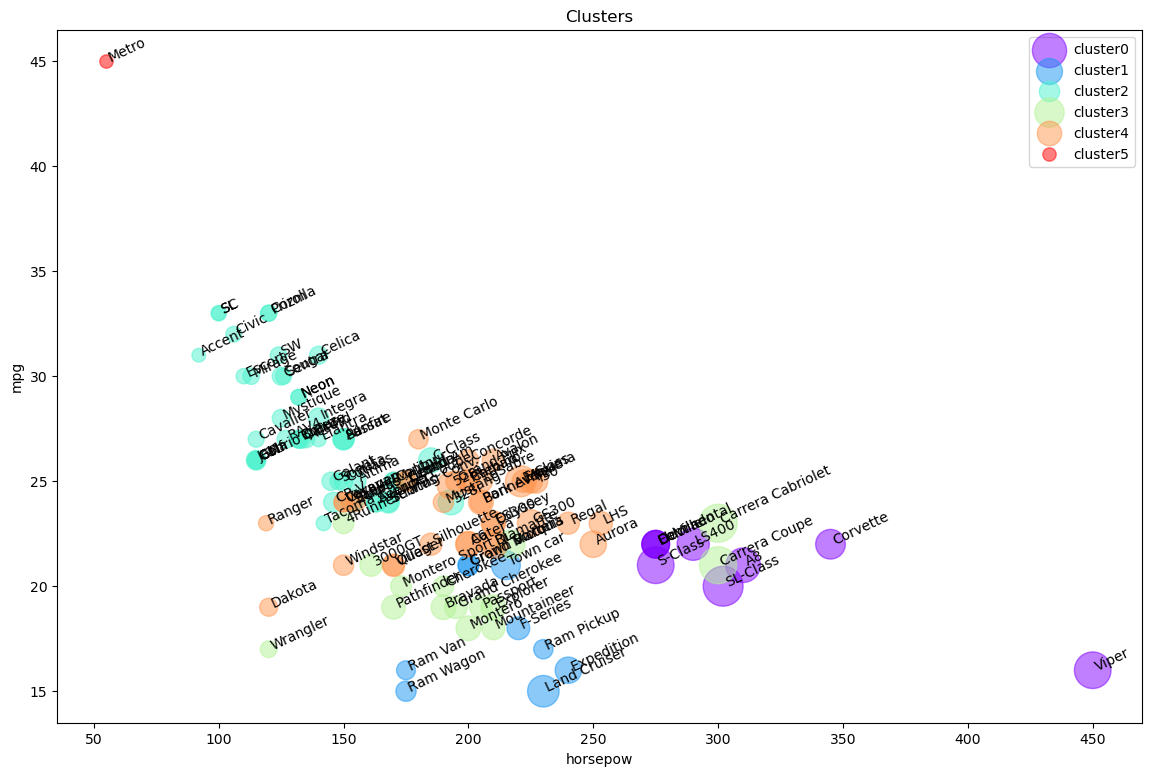

In [48]:
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(14,9))

for label, color in zip(range(n_clusters), colors):
    subset = df[df.cluster_ == label]
    for i in subset.index:
        plt.text(subset.horsepow[i], subset.mpg[i], str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*10, c=[color], label='cluster'+str(label), alpha=0.5)

plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')


We are observing the distribution of each cluster on the scatter plot, but it is not clear where the centroid of each cluster is. Furthermore, there are 2 types of vehicles in our dataset, "truck" (value of 1 in the type column) and "car." Therefore, we use them to distinguish the classes and summarize the cluster. 

First, we count the number of cases in each group.

In [46]:
df.groupby(['cluster_','type'])['cluster_'].count()

cluster_  type
0         0.0      9
1         0.0      3
          1.0      6
2         0.0     43
          1.0      3
3         0.0      4
          1.0     11
4         0.0     28
          1.0      9
5         0.0      1
Name: cluster_, dtype: int64

Now we see the characteristics of each cluster.

In [47]:
agg_cars = df.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()
agg_cars

/tmp/ipykernel_321769/2585305412.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  agg_cars = df.groupby(['cluster_','type'])['horsepow','engine_s','mpg','price'].mean()


horsepow  engine_s        mpg      price
cluster_ type                                            
0        0.0   310.777778  5.000000  20.888889  55.819444
1        0.0   205.000000  4.600000  21.000000  29.376667
         1.0   211.666667  4.483333  16.166667  29.024667
2        0.0   137.418605  2.165116  27.511628  17.244605
         1.0   138.333333  2.133333  24.666667  16.322000
3        0.0   244.500000  3.125000  21.750000  53.217500
         1.0   183.000000  3.500000  19.181818  26.053091
4        0.0   204.785714  3.328571  24.135714  28.053393
         1.0   158.222222  2.922222  22.000000  21.012111
5        0.0    55.000000  1.000000  45.000000   9.235000

We have 3 main clusters with the majority of vehicles in them:

**Cars**:

-   Cluster 1: Nearly high mpg and low horsepower
-   Cluster 2: Good mpg and horsepower, but high price
-   Cluster 3: Low mpg, high horsepower, and high price


**Trucks**:

-   Cluster 1: Nearly high mpg within trucks, low horsepower, and price
-   Cluster 2: Nearly low mpg, medium horsepower, and high price
-   Cluster 3: Good mpg and horsepower, low price


Text(0, 0.5, 'mpg')

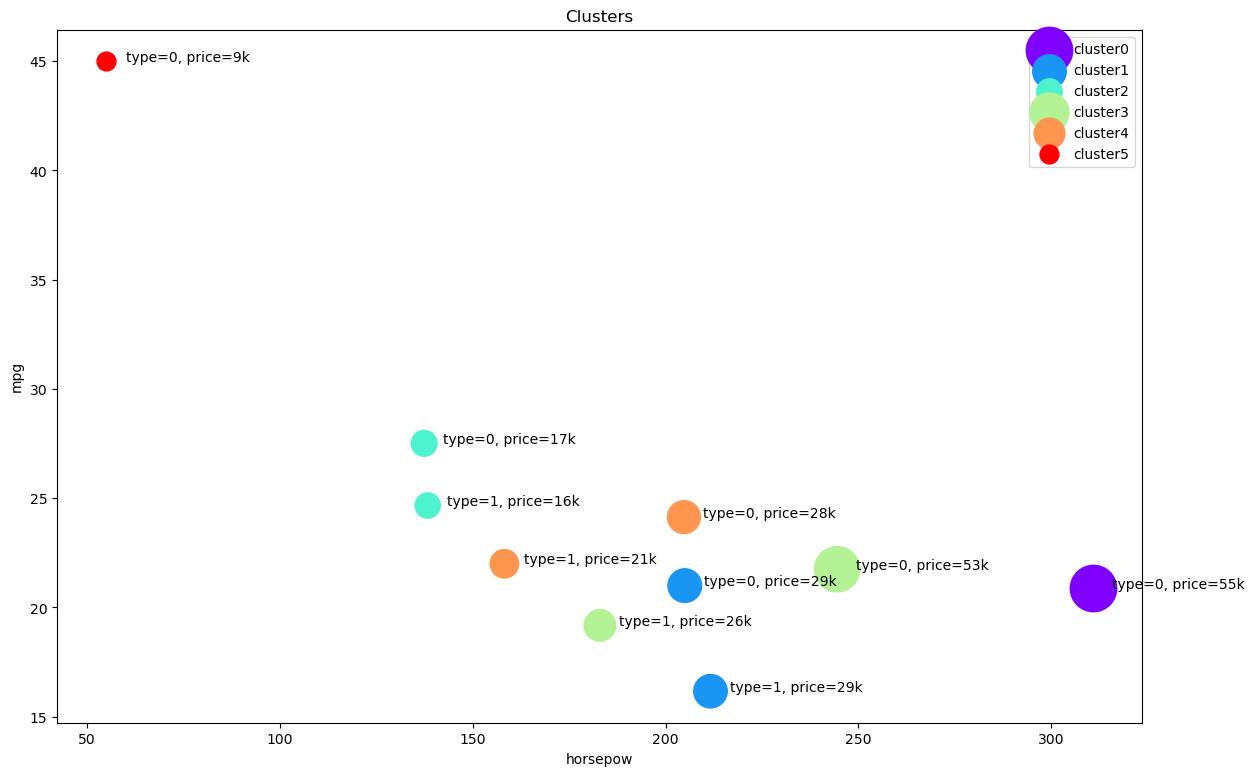

In [50]:
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

plt.figure(figsize=(14,9))
for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*20, c=[color], label='cluster'+str(label))
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')

<a name="annex"></a>
## <b> <font color='green'> ANNEX </a>

### Hierarchical Clustering

Hierarchical clustering algorithms create a hierarchy of clusters where each node is a cluster consisting of the clusters of its child nodes. 
The strategies for hierarchical clustering are divided into two types:

Divisive:

- It is a top-down approach, so it starts with all observations in one large group and divides it into smaller pieces.
- Think of division as splitting the cluster.

Agglomerative:

- It is a bottom-up approach, where each observation starts in its own cluster and pairs of clusters merge as they move up in the hierarchy.

<img src="images/types_clustering.png" width="40%"></img>

### Dendogram

A dendrogram is a diagram representing a tree. 


Each combination is represented by a horizontal line. When moving from the bottom layer to the top node, a dendrogram allows us to reconstruct the history of merges that led to the represented clustering.

<img src="images/dendogram_example.png"/>

### Algorithm for agglomerative hierarchical clustering. 

Algorithm for agglomerative hierarchical clustering: Let's say our dataset has n points, then:

1. We create n clusters, one for each data point. Each point is assigned as a cluster.
2. We calculate the proximity or distance matrix, which will be n x n.
3. We iteratively perform the following steps until the specified number of clusters is reached or only one cluster remains:
    1. We combine the 2 closest clusters; the distances are already obtained in the proximity matrix.
    2. The proximity matrix is updated with the new values.


In the proximity matrix, we need to measure the distances between the clusters. Also, we must merge the clusters that are closest. Calculating the proximity between clusters with a single point and also clusters with multiple data points is key. There are questions that need to be answered:
- How do we measure distances between these clusters?
- How do we define the closest among the clusters?
- What points do we use?

First, let's see how to calculate the distance between two clusters with one point each. Let's suppose we have a dataset of patients and we want to group them using hierarchical clustering. So, our data points are patients with a set of, for example, 3 dimensions, let them be age, body mass index, and blood pressure to fix ideas. We can use different distances to calculate the proximity matrix, for example, the Euclidean distance. Therefore, if we have a dataset of n patients, we can build an n x n dissimilarity distance matrix. This will give us the distance of clusters with one data point.

How can we calculate the distance between clusters when there are multiple patients in each group?

We can use different criteria to find the closest clusters and merge them.

In general, it depends on:
- The type of data.
- The dimensionality of the data.
- The domain knowledge of the dataset.


Different approaches to defining the distance between clusters distinguish different algorithms. There are several ways we can do this.
- Single-linkage clustering.
  - Single linkage is defined as the shortest distance between two points in each cluster.
  
  
- Complete-linkage clustering.
  - We look for the longest distance between the points of each cluster.


- Average-linkage clustering.
  - We look for the average distance from each point in one cluster to each point in another cluster.


- Centroid-linkage clustering.
  - The centroid is the average of the sets of point entities in a cluster. This linkage takes into account the centroid of each cluster when determining the minimum distance.


<a name='references'></a>
## <b> <font color='green'> References </a>

<a href="https://www.coursera.org/professional-certificates/ibm-data-science" target='blanck'>
IBM Data Science Coursera </a>
